# Plot SARI timeseries

### Setup

In [1]:
import sys
sys.path.append('../')
from src.hp_tuning_functions import *
from src.realtime_utils import *

In [2]:
from plotnine import *

# Load data

In [3]:
targets, covariates = load_realtime_training_data()

In [4]:
test_end = get_season_end(2023)
validation_end = get_season_end(2022)
train_end = get_season_end(2021)

In [5]:
validation_end

Timestamp('2023-10-01 00:00:00')

In [6]:
validation_end = pd.Timestamp('2023-11-16')

In [7]:
test_end = pd.Timestamp('2024-10-06')

In [8]:
targets = targets[:test_end]

In [9]:
df = targets.pd_dataframe().reset_index()

In [10]:
df.columns

Index(['date', 'icosari-sari-DE', 'icosari-sari-00-04', 'icosari-sari-05-14',
       'icosari-sari-15-34', 'icosari-sari-35-59', 'icosari-sari-60-79',
       'icosari-sari-80+'],
      dtype='object', name='component')

In [11]:
highlight_areas = pd.DataFrame({
    "xmin": [targets.start_time(), train_end, validation_end],
    "xmax": [train_end, validation_end, test_end],
    "period": ["Train", "Validation", "Test"]  
})

In [12]:
covid_start = pd.Timestamp("2020-03-11")

In [13]:
covid_start = pd.Timestamp('2019-06-30')
covid_end = pd.Timestamp('2023-07-03')

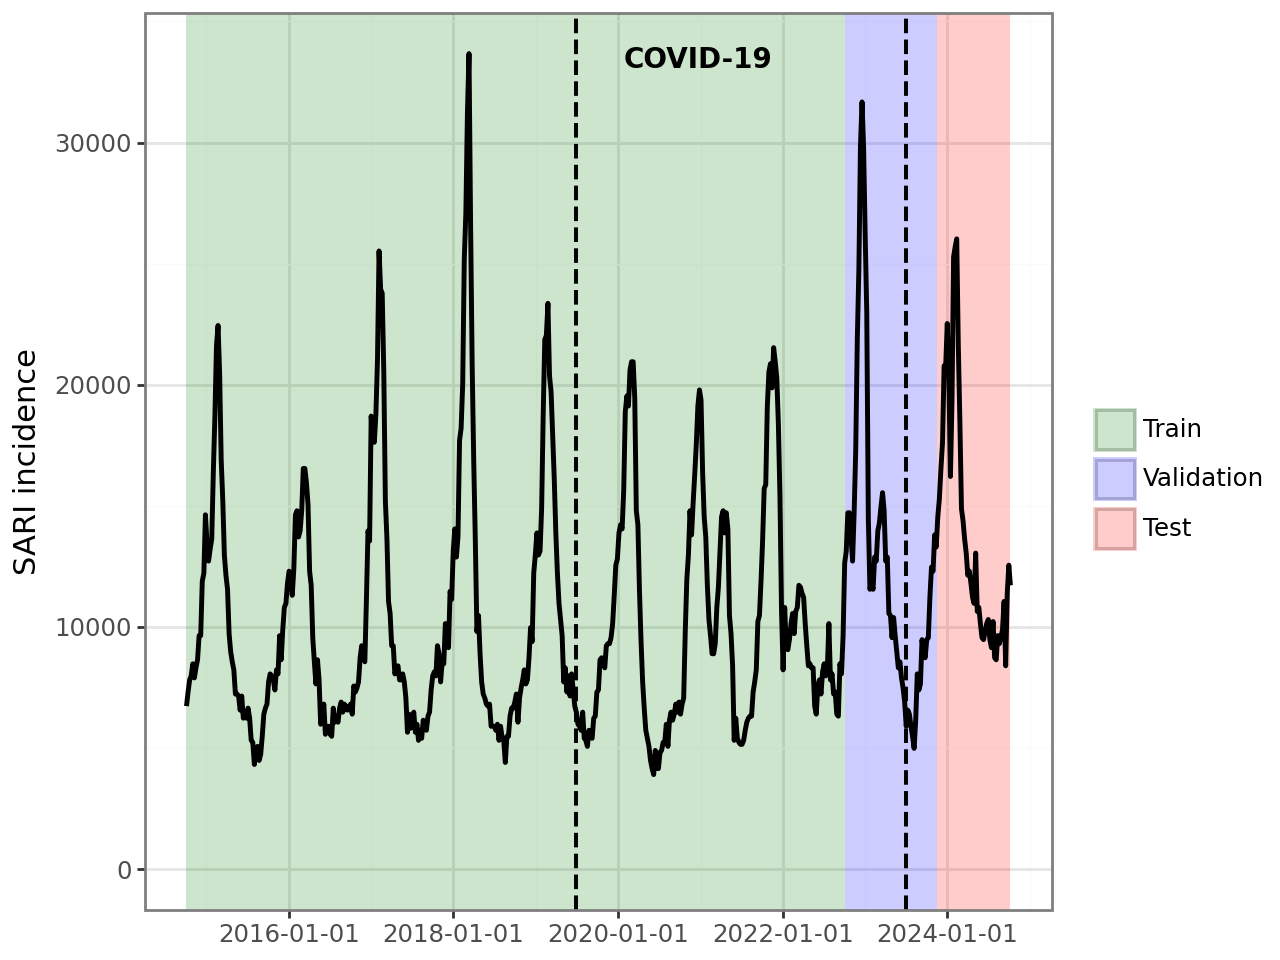

In [14]:
plot = (
    ggplot() +
    
    # Use geom_rect with the highlight_areas DataFrame and map fill to the label
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    
    # Vertical dashed line at the start of COVID-19
    geom_vline(
        xintercept=covid_start,
        linetype="dashed",
        color="black",
        size=0.8
    ) +
    geom_vline(
        xintercept=covid_end,
        linetype="dashed",
        color="black",
        size=0.8
    ) +
    
    # Label for COVID-19 start
    annotate(
        "text",
        x=covid_start + pd.Timedelta(weeks=30),
        y=df['icosari-sari-DE'].max() * 0.975,  # Slightly below the max y value for positioning
        label="COVID-19",
        ha="left",  # Align text to the left of the line
        va="bottom",  # Position text just above the line
        size=10,
        color="black",
        fontweight="bold"
    ) +
    
    # Add the time series line
    geom_line(df, aes(x='date', y='icosari-sari-DE'), size=1) +
    
    # Customize labels and scales
    labs(
        x="",
        y="SARI incidence",
        fill=""  # Legend title for the areas
    ) +
    scale_x_date(date_breaks='2 year', minor_breaks='1 year') +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + # To order the legend
    
    # Customize theme
    theme_bw() +
    theme(legend_position="right")
)

plot

In [57]:
plot.save("../figures/sari_periods.pdf", width = 165, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/sari_periods.pdf


# Different data versions

In [67]:
dates = ['2023-09-03', '2023-10-01', '2023-11-05', '2023-12-03', '2024-01-07']

In [68]:
def load_data_version(as_of):
    target_sari = load_target_series('sari', as_of, age_group='00+')
    latest_sari = load_latest_series('sari')

    return concatenate([latest_sari['icosari-sari-DE'].drop_after(target_sari[-4:].start_time()), target_sari[-4:]])

In [69]:
dfs = []
for date in dates:
    print(date)
    df_temp = load_data_version(date)
    df_temp = df_temp['icosari-sari-DE'][pd.Timestamp('2023-07-01'):].pd_dataframe().reset_index()
    df_temp['data_version'] = date
    dfs.append(df_temp)

2023-09-03


2023-10-01


2023-11-05
2023-12-03


2024-01-07


In [70]:
df = pd.concat(dfs)

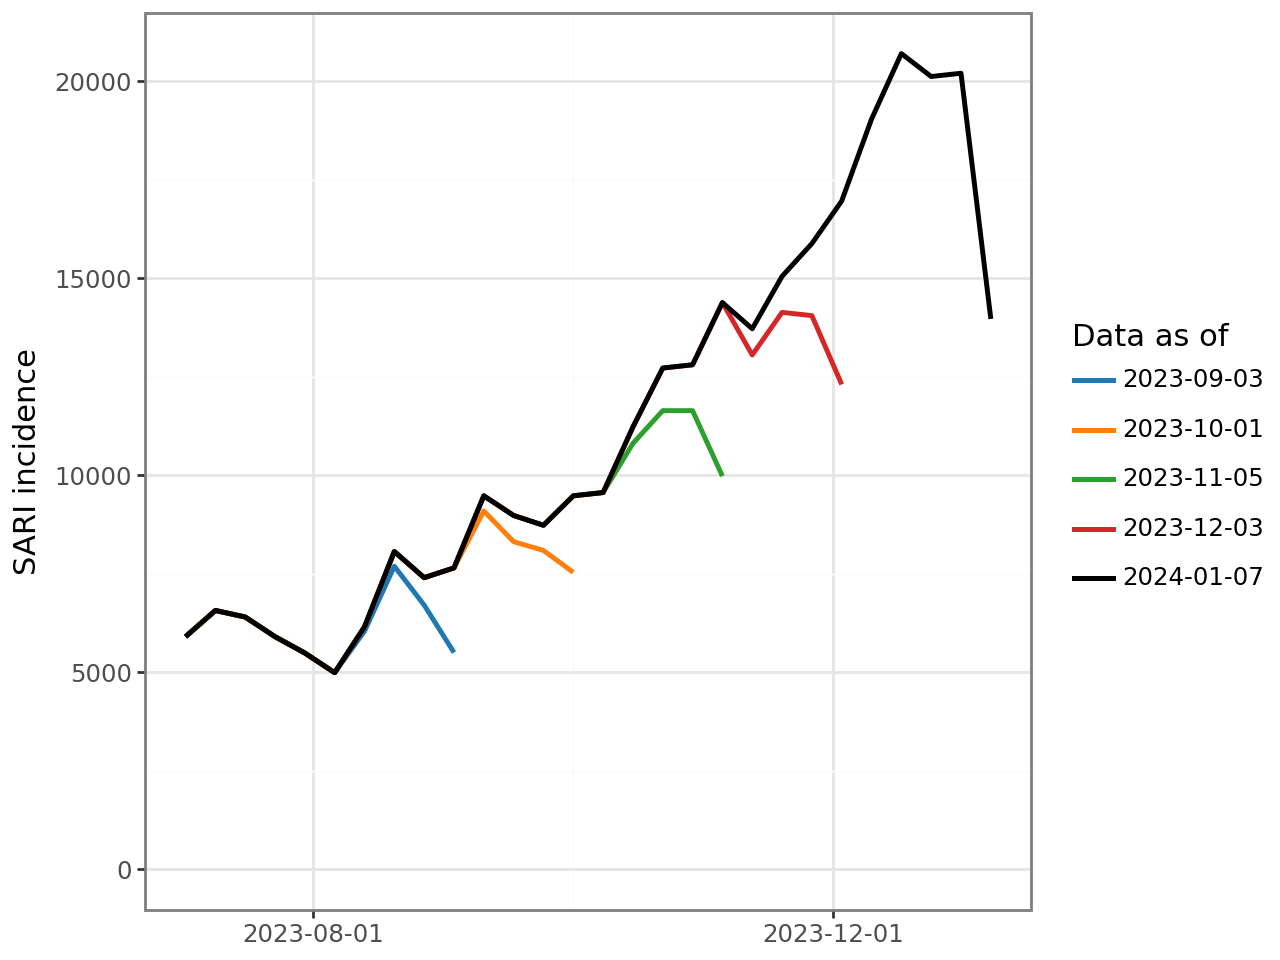

In [77]:
plot = (
    ggplot() +
    geom_line(df, aes(x='date', y='icosari-sari-DE', color='data_version'), size=1) +
    
    # Customize labels and scales
    labs(
        x="",
        y="SARI incidence",
        color="Data as of"
    ) +
    scale_x_date( # date_breaks='4 month', minor_breaks='1 month'
     breaks=[pd.Timestamp('2023-08-01'), pd.Timestamp('2023-12-01')]
    ) +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_color_manual(values={
        '2023-09-03': '#1f77b4',  # Blue
        '2023-10-01': '#ff7f0e',  # Orange
        '2023-11-05': '#2ca02c',  # Green
        '2023-12-03': '#d62728',  # Red
        '2024-01-07': '#000000',  # Black
    }, limits=dates) + # To order the legend
    
    # Customize theme
    theme_bw() +
    theme(legend_position="right",
          legend_key=element_blank())
)

plot

In [79]:
plot.save("../figures/revision.pdf", width = 90, height = 90, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 90.00000000000001 x 90.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/revision.pdf
